# Insightface+GFPGAN Face Swap
# ``` Swap a specific face or a single face.```

For Image Upscale
[GFPGAN](https://github.com/TencentARC/GFPGAN) <Br>
For Faceswap
[insightface](https://github.com/deepinsight/insightface) <BR>
Some Code Copied from
[roop](https://github.com/s0md3v/roop) <Br>
Unable To Run Gradio Due to ```Disconnect Runtime Error``` <Br>
<!-- Copied From https://github.com/s0md3v/roop  -->
# Disclaimer
This software is designed to contribute positively to the AI-generated media industry, assisting artists with tasks like character animation and models for clothing.

We are aware of the potential ethical issues and have implemented measures to prevent the software from being used for inappropriate content, such as nudity.

Users are expected to follow local laws and use the software responsibly. If using real faces, get consent and clearly label deepfakes when sharing. The developers aren't liable for user actions.
# Licenses
This software uses a lot of third party libraries as well pre-trained models. The users should keep in mind that these third party components have their own license and terms, therefore our license is not being applied.

In [ ]:
#@title Install and Download Model { display-mode: "form" }
from google.colab import output
output.eval_js('new Audio("https://github.com/neuralfalcon/Roop-Image-FaceSwap/raw/main/start.mp3").play()')
requirements_content = """numpy==1.24.3
opencv-python==4.8.0.74
onnx==1.14.0
insightface==0.7.3
psutil==5.9.5
pillow==10.0.0
protobuf==4.23.4
tqdm==4.65.0
addict
future
lmdb
pyyaml
requests
scikit-image
scipy
yapf
lpips
gdown
# onnxruntime-gpu==1.15.1
"""

# Specify the file path
file_path = "/content/requirements.txt"

# Write the content to the file
with open(file_path, "w") as file:
    file.write(requirements_content)
# Clone GFPGAN and enter the GFPGAN folder
# pip install https://github.com/karaokenerds/python-audio-separator/releases/download/v0.12.1/onnxruntime_gpu-1.17.0-cp310-cp310-linux_x86_64.whl
import tensorflow as tf
gpu_available = tf.config.list_physical_devices('GPU')
if gpu_available:
  os.system("pip install https://github.com/karaokenerds/python-audio-separator/releases/download/v0.12.1/onnxruntime_gpu-1.17.0-cp310-cp310-linux_x86_64.whl")
else:
  pass
# !pip install -r /content/requirements.txt
import os
os.system("pip install -r /content/requirements.txt")
%cd /content
!rm -rf /content/GFPGAN
!git clone https://github.com/TencentARC/GFPGAN.git
%cd /content/GFPGAN

# Set up the environment
# Install basicsr - https://github.com/xinntao/BasicSR
# We use BasicSR for both training and inference
!pip install basicsr
# Install facexlib - https://github.com/xinntao/facexlib
# We use face detection and face restoration helper in the facexlib package
!pip install facexlib
# Install other depencencies
!pip install -r requirements.txt
!python setup.py develop
!pip install realesrgan  # used for enhancing the background (non-face) regions
#Google Colab baning gradio links
# !pip install -q yacs av gradio
import torch
if torch.cuda.is_available():
  print("GPU is available!")
  var=os.system("pip install https://github.com/karaokenerds/python-audio-separator/releases/download/v0.12.1/onnxruntime_gpu-1.17.0-cp310-cp310-linux_x86_64.whl")
  if var!=0:
    print("Failed to install onnxruntime_gpu ")
    print("pip install https://github.com/karaokenerds/python-audio-separator/releases/download/v0.12.1/onnxruntime_gpu-1.17.0-cp310-cp310-linux_x86_64.whl")
else:
  var=os.system("pip install onnxruntime==1.17.1")
  if var!=0:
    print("Failed to install onnxruntime ")
    print("pip install onnxruntime==1.17.1")
# Download the pre-trained model
# !wget https://github.com/TencentARC/GFPGAN/releases/download/v0.2.0/GFPGANCleanv1-NoCE-C2.pth -P experiments/pretrained_models
# Now we use the V1.3 model for the demo
# !wget https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth -P experiments/pretrained_models
%cd /content
import os
from google.colab import files
import shutil
from zipfile import ZipFile
from tqdm import tqdm
import urllib
def conditional_download(url, download_file_path):
    print(f"Downloading {os.path.basename(download_file_path)}")
    base_path = os.path.dirname(download_file_path)

    if not os.path.exists(base_path):
        os.makedirs(base_path)

    if os.path.exists(download_file_path):
        os.remove(download_file_path)

    try:
        request = urllib.request.urlopen(url)  # type: ignore[attr-defined]
        total = int(request.headers.get('Content-Length', 0))
    except urllib.error.URLError as e:
        print(f"Error: Unable to open the URL - {url}")
        print(f"Reason: {e.reason}")
        return

    with tqdm(total=total, desc='Downloading', unit='B', unit_scale=True, unit_divisor=1024) as progress:
        try:
            urllib.request.urlretrieve(url, download_file_path, reporthook=lambda count, block_size, total_size: progress.update(block_size))  # type: ignore[attr-defined]
        except urllib.error.URLError as e:
            print(f"Error: Failed to download the file from the URL - {url}")
            print(f"Reason: {e.reason}")
            return

    print(f"Download successful!")
    print(f"URL: {url}")
    print(f"Save at: {download_file_path}")


def extract_zip(zip_file_path,extract_path):
    # Create the extraction directory if it doesn't exist
    os.makedirs(extract_path, exist_ok=True)
    # Open the ZIP file
    with ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all contents to the specified directory
        zip_ref.extractall(extract_path)
    print(f"Contents of '{zip_file_path}' extracted to '{extract_path}'.")
inswapper_128 = 'https://huggingface.co/countfloyd/deepfake/resolve/main/inswapper_128.onnx'  # @param {type: "string"}
inswapper_128_fp16 = 'https://github.com/Hillobar/Rope/releases/download/Sapphire/inswapper_128.fp16.onnx'  # @param {type: "string"}
buffalo_l = 'https://github.com/deepinsight/insightface/releases/download/v0.7/buffalo_l.zip'  # @param {type: "string"}
conditional_download(inswapper_128,"/content/checkpoints/inswapper_128.onnx")
# print("Downloading inswapper_128.fp16.onnx")
conditional_download(inswapper_128_fp16,"/content/checkpoints/inswapper_128.fp16.onnx")
# print("Downloading buffalo_l.zip")
conditional_download(buffalo_l,"/content/buffalo_l.zip")
extract_zip("/content/buffalo_l.zip","/content/checkpoints/models/buffalo_l")




gfpgan_model = 'https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.4.pth '  # @param {type: "string"}
conditional_download(gfpgan_model,"/content/GFPGAN/experiments/pretrained_models/GFPGANv1.3.pth")
RealESRGAN = 'https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth'  # @param {type: "string"}
conditional_download(RealESRGAN,"/content/GFPGAN/gfpgan/weights/RealESRGAN_x2plus.pth")
detection_Resnet50 = 'https://github.com/xinntao/facexlib/releases/download/v0.1.0/detection_Resnet50_Final.pth'  # @param {type: "string"}
conditional_download(detection_Resnet50,"/content/GFPGAN/gfpgan/weights/detection_Resnet50_Final.pth")
parsing_parsenet = 'https://github.com/xinntao/facexlib/releases/download/v0.2.2/parsing_parsenet.pth'  # @param {type: "string"}
conditional_download(parsing_parsenet,"/content/GFPGAN/gfpgan/weights/parsing_parsenet.pth")
inference_gfpgan = 'https://raw.githubusercontent.com/neuralfalcon/DreamTalk-Colab-Demo/main/inference_gfpgan.py'  # @param {type: "string"}
conditional_download(inference_gfpgan,"/content/GFPGAN/inference_gfpgan.py")

import requests
import sys
import shutil
def fix():
  url = "https://raw.githubusercontent.com/neuralfalcon/DreamTalk-Colab-Demo/main/degradations.py"
  filename = "/content/degradations.py"
  full_version = sys.version.split(' ')[0]
  major_minor_version = '.'.join(full_version.split('.')[:2])
  basicsr_path=f"/usr/local/lib/python{major_minor_version}/dist-packages/basicsr/data/degradations.py"
  # Send a GET request to the URL
  response = requests.get(url)
  # Check if the request was successful (status code 200)
  if response.status_code == 200:
      # Write the content to a file
      with open(filename, 'wb') as file:
          file.write(response.content)
      try:
        shutil.copy("/content/degradations.py",basicsr_path)
        print(f"Copied to {basicsr_path}")
      except:
        print("Update the 'basicsr_path' variable -- replace '{major_minor_version}' with the current Python version in Google Colab, such as 3.10.")

  else:
      print("Failed to download the file.")
fix()

from IPython.display import clear_output
clear_output()
from google.colab import output
output.eval_js('new Audio("https://github.com/neuralfalcon/Roop-Image-FaceSwap/raw/main/install_voice.mp3").play()')
import time
time.sleep(7)

import os
os.kill(os.getpid(), 9)

In [ ]:
#@title utils.py
"""
This project is developed by Haofan Wang to support face swap in single frame. Multi-frame will be supported soon!

It is highly built on the top of insightface, sd-webui-roop and CodeFormer.
"""

import os
import cv2
import copy
import argparse
import insightface
import onnxruntime
import numpy as np
from PIL import Image
from typing import List, Union, Dict, Set, Tuple

import os
# Create directories if they do not exist
os.makedirs("/content/upscale", exist_ok=True)
os.makedirs("/content/swapface", exist_ok=True)
os.makedirs("/content/crop", exist_ok=True)
os.makedirs("/content/download", exist_ok=True)

# Set the CUDA_VISIBLE_DEVICES environment variable to the index of your GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Replace '0' with the index of your GPU

# Rest of your script...

def getFaceSwapModel(model_path: str):
    model = insightface.model_zoo.get_model(model_path)
    return model


# def getFaceAnalyser(model_path: str, providers,
#                     det_size=(320, 320)):

#     face_analyser = insightface.app.FaceAnalysis(name="buffalo_l", root="/content/inswapper/checkpoints", providers=providers)
#     face_analyser.prepare(ctx_id=0, det_size=det_size)
#     return face_analyser

def getFaceAnalyser(providers, det_size=(320, 320)):
    print("Available Providers before:", onnxruntime.get_available_providers())
    face_analyser = insightface.app.FaceAnalysis(
        name="buffalo_l", root="/content/checkpoints", providers=providers
    )
    print("Available Providers after:", onnxruntime.get_available_providers())
    face_analyser.prepare(ctx_id=0, det_size=det_size)
    return face_analyser


def get_one_face(face_analyser,
                 frame:np.ndarray):
    face = face_analyser.get(frame)
    try:
        return min(face, key=lambda x: x.bbox[0])
    except ValueError:
        return None


def get_many_faces(face_analyser,
                   frame:np.ndarray):
    """
    get faces from left to right by order
    """
    try:
        face = face_analyser.get(frame)
        return sorted(face, key=lambda x: x.bbox[0])
    except IndexError:
        return None


def swap_face(face_swapper,
              source_faces,
              target_faces,
              source_index,
              target_index,
              temp_frame):
    """
    paste source_face on target image
    """
    source_face = source_faces[source_index]
    target_face = target_faces[target_index]

    return face_swapper.get(temp_frame, target_face, source_face, paste_back=True)


def process(source_img: Union[Image.Image, List],
            target_img: Image.Image,
            source_indexes: str,
            target_indexes: str,
           face_analyser,face_swapper):
    # read target image
    target_img = cv2.cvtColor(np.array(target_img), cv2.COLOR_RGB2BGR)

    # detect faces that will be replaced in the target image
    target_faces = get_many_faces(face_analyser, target_img)
    num_target_faces = len(target_faces)
    num_source_images = len(source_img)

    if target_faces is not None:
        temp_frame = copy.deepcopy(target_img)
        if isinstance(source_img, list) and num_source_images == num_target_faces:
            print("Replacing faces in target image from the left to the right by order")
            for i in range(num_target_faces):
                source_faces = get_many_faces(face_analyser, cv2.cvtColor(np.array(source_img[i]), cv2.COLOR_RGB2BGR))
                source_index = i
                target_index = i

                if source_faces is None:
                    raise Exception("No source faces found!")

                temp_frame = swap_face(
                    face_swapper,
                    source_faces,
                    target_faces,
                    source_index,
                    target_index,
                    temp_frame
                )
        elif num_source_images == 1:
            # detect source faces that will be replaced into the target image
            source_faces = get_many_faces(face_analyser, cv2.cvtColor(np.array(source_img[0]), cv2.COLOR_RGB2BGR))
            num_source_faces = len(source_faces)
            print(f"Source faces: {num_source_faces}")
            print(f"Target faces: {num_target_faces}")

            if source_faces is None:
                raise Exception("No source faces found!")

            if target_indexes == "-1":
                if num_source_faces == 1:
                    print("Replacing all faces in target image with the same face from the source image")
                    num_iterations = num_target_faces
                elif num_source_faces < num_target_faces:
                    print("There are less faces in the source image than the target image, replacing as many as we can")
                    num_iterations = num_source_faces
                elif num_target_faces < num_source_faces:
                    print("There are less faces in the target image than the source image, replacing as many as we can")
                    num_iterations = num_target_faces
                else:
                    print("Replacing all faces in the target image with the faces from the source image")
                    num_iterations = num_target_faces

                for i in range(num_iterations):
                    source_index = 0 if num_source_faces == 1 else i
                    target_index = i

                    temp_frame = swap_face(
                        face_swapper,
                        source_faces,
                        target_faces,
                        source_index,
                        target_index,
                        temp_frame
                    )
            else:
                print("Replacing specific face(s) in the target image with specific face(s) from the source image")

                if source_indexes == "-1":
                    source_indexes = ','.join(map(lambda x: str(x), range(num_source_faces)))

                if target_indexes == "-1":
                    target_indexes = ','.join(map(lambda x: str(x), range(num_target_faces)))

                source_indexes = source_indexes.split(',')
                target_indexes = target_indexes.split(',')
                num_source_faces_to_swap = len(source_indexes)
                num_target_faces_to_swap = len(target_indexes)

                if num_source_faces_to_swap > num_source_faces:
                    raise Exception("Number of source indexes is greater than the number of faces in the source image")

                if num_target_faces_to_swap > num_target_faces:
                    raise Exception("Number of target indexes is greater than the number of faces in the target image")

                if num_source_faces_to_swap > num_target_faces_to_swap:
                    num_iterations = num_source_faces_to_swap
                else:
                    num_iterations = num_target_faces_to_swap

                if num_source_faces_to_swap == num_target_faces_to_swap:
                    for index in range(num_iterations):
                        source_index = int(source_indexes[index])
                        target_index = int(target_indexes[index])

                        if source_index > num_source_faces-1:
                            raise ValueError(f"Source index {source_index} is higher than the number of faces in the source image")

                        if target_index > num_target_faces-1:
                            raise ValueError(f"Target index {target_index} is higher than the number of faces in the target image")

                        temp_frame = swap_face(
                            face_swapper,
                            source_faces,
                            target_faces,
                            source_index,
                            target_index,
                            temp_frame
                        )
        else:
            raise Exception("Unsupported face configuration")
        result = temp_frame
    else:
        print("No target faces found!")

    result_image = Image.fromarray(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    return result_image


import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_images(donor_image_path, target_image_path, swapped_face_path, upscale_swap_face_path):
    # Load images
    donor_image = mpimg.imread(donor_image_path)
    target_image = mpimg.imread(target_image_path)
    swapped_face = mpimg.imread(swapped_face_path)
    upscale_swap_face = mpimg.imread(upscale_swap_face_path)

    # Create a figure with 1 row and 4 columns
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    # Display donor image
    axs[0].imshow(donor_image)
    axs[0].axis('off')
    axs[0].set_title('Source Image')

    # Display target image
    axs[1].imshow(target_image)
    axs[1].axis('off')
    axs[1].set_title('Target Image')

    # Display swapped face
    axs[2].imshow(swapped_face)
    axs[2].axis('off')
    axs[2].set_title('Swapped Face')

    # Display upscaled swapped face
    axs[3].imshow(upscale_swap_face)
    axs[3].axis('off')
    axs[3].set_title('Upscaled Swapped Face')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
# display_images("donor_image.jpg", "target_image.jpg", "swapped_face.jpg", "upscale_swap_face.jpg")

def display_image(image_path):
    # Read the image using matplotlib.image.imread
    img = mpimg.imread(image_path)

    # Display the image using matplotlib.pyplot.imshow
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels
    plt.show()


import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Assuming you have the get_many_faces function defined somewhere
# Assuming face_data is a list of dictionaries with 'bbox' key containing bounding box coordinates
Face_Dict_Store={}
def scan_faces(target_image_path):
  global Face_Dict_Store
  input_image = cv2.imread(target_image_path)
  face_data = get_many_faces(face_analyser, input_image)
  face_dict = {}

  num_faces = len(face_data)
  cols = 3  # Number of columns in the grid
  rows = (num_faces + cols - 1) // cols  # Calculate number of rows needed

  fig, axes = plt.subplots(rows, cols, figsize=(5, 6), gridspec_kw={'hspace': 0, 'wspace': 0})  # Set the figure size dynamically and remove padding

  for index, (ax, face_info) in enumerate(zip(axes.ravel(), face_data)):
      face_dict[index] = face_info
      x1, y1, x2, y2 = map(int, face_info['bbox'])  # Convert bounding box coordinates to integers
      face_crop = input_image[y1:y2, x1:x2]  # Crop the face from the input image
      ax.imshow(cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB), aspect='equal')  # Display the face crop with equal aspect ratio
      ax.text(10, 30, str(index), color='black', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))  # Add index as text
      ax.axis('off')  # Turn off axis
  Face_Dict_Store=face_dict
  # Hide any unused subplots
  for ax in axes.ravel()[num_faces:]:
      ax.axis('off')

  plt.tight_layout()

  # Save the final image
  plt.savefig('/content/scan_data.png', bbox_inches='tight')
  return face_dict,'/content/scan_data.png'
import shutil
import os
import cv2
def image_upscale(input_image):
  if os.path.exists("/content/GFPGAN/results"):
    shutil.rmtree("/content/GFPGAN/results")
  if os.path.exists("/content/GFPGAN/inputs/upload"):
    shutil.rmtree("/content/GFPGAN/inputs/upload")
  if not  os.path.exists("/content/save"):
    os.mkdir("/content/save")
  os.mkdir("/content/GFPGAN/inputs/upload")
  base_filename = os.path.basename(input_image)
  shutil.copy(input_image,f"/content/GFPGAN/inputs/upload/{base_filename}")
  os.chdir("/content/GFPGAN")
  var=os.system('python inference_gfpgan.py -i inputs/upload -o results -v 1.3 -s 2 --bg_upsampler realesrgan')
  if var==0:
    print("success")
    shutil.copy(f"/content/GFPGAN/results/restored_imgs/{base_filename}",f"/content/save/swap_{base_filename}")
    return f"/content/save/swap_{base_filename}"
  else:
    print("failed")
    return None


def extract_face_crop(input_image, x1, y1, x2, y2, initial_area=30, area_decrement=5):
    area = initial_area
    bbox=None
    while area > 0:
        try:
            x1_adjusted = max(0, x1 - area)
            y1_adjusted = max(0, y1 - area)
            x2_adjusted = min(input_image.shape[1], x2 + area)
            y2_adjusted = min(input_image.shape[0], y2 + area)
            bbox=[x1_adjusted,y1_adjusted,x2_adjusted,y2_adjusted]
            face_crop = input_image[y1_adjusted:y2_adjusted, x1_adjusted:x2_adjusted]
            return face_crop,bbox
        except:
            area -= area_decrement

    return None,None

import os
import uuid

def generate_random_filename(source_img_path):
    # Extract only the filename without the directory path
    filename = os.path.basename(source_img_path)
    # Split the filename into name and extension
    name, extension = os.path.splitext(filename)
    # Generate a random UUID
    random_uuid = str(uuid.uuid4())[:6]
    # Create the new filename with the random UUID and original extension
    new_filename = f"{name}_{random_uuid}{extension}"
    return new_filename


def roop_face_swap(source_img_path,target_img_path,face_id):
  global face_analyser,face_swapper
  source_img = [Image.open(source_img_path)]
  target_img = Image.open(target_img_path)
  source_indexes="-1"


  if face_id is not None:
    target_indexes=str(face_id).strip()
  else:
    target_indexes="-1"
  print(f"face id is {target_indexes}")
  result_image=process(source_img,target_img,source_indexes,target_indexes,face_analyser,face_swapper)
  new_filename = generate_random_filename(source_img_path)
  new_filename=f"/content/swapface/swap_{new_filename}"
  result_image.save(new_filename)
  result_array_rgb = np.array(result_image)
  result_array_bgr = cv2.cvtColor(result_array_rgb, cv2.COLOR_RGB2BGR)
  return new_filename,result_image,result_array_bgr


  final_image=image_upscale(new_filename)
  print(final_image)
  return final_image

def process_image(source_img_path,target_img_path,face_id,Upscale_Full_Image):
  swap_face_path,result_image,result_array_bgr=roop_face_swap(source_img_path,target_img_path,face_id)
  if face_id and Upscale_Full_Image==False:
    input_image = cv2.imread(swap_face_path)
    input_image=result_array_bgr
    x1, y1, x2, y2 = map(int, Face_Dict_Store[face_id]['bbox'])
    # face_crop = input_image[y1:y2, x1:x2]
    face_crop,bbox = extract_face_crop(input_image, x1, y1, x2, y2, initial_area=30, area_decrement=5)
    x1, y1, x2, y2=bbox
    crop_face_path="/content/crop/crop_"+generate_random_filename(swap_face_path)
    cv2.imwrite(crop_face_path,face_crop)
    crop_upscaled_image_path=image_upscale(crop_face_path)
    upscaled_image=cv2.imread(crop_upscaled_image_path)
    upscaled_image_resized = cv2.resize(upscaled_image, (x2 - x1, y2 - y1))
    input_image[y1:y2, x1:x2] = upscaled_image_resized
    upscaled_image_path="/content/download/upscale_face_swap_"+generate_random_filename(source_img_path)
    cv2.imwrite(upscaled_image_path,input_image)
  elif face_id and Upscale_Full_Image==True:
    full_face_swap_path=image_upscale(swap_face_path)
    upscaled_image_path="/content/download/upscale_face_swap_"+generate_random_filename(source_img_path)
    shutil.copy(full_face_swap_path,upscaled_image_path)
  else:
    full_face_swap_path=image_upscale(swap_face_path)
    upscaled_image_path="/content/download/upscale_face_swap_"+generate_random_filename(source_img_path)
    shutil.copy(full_face_swap_path,upscaled_image_path)
  return swap_face_path,upscaled_image_path

In [ ]:
#@title Select Model  [128 little slow  and 128.fp16 fast]
providers=onnxruntime.get_available_providers()
face_analyser=getFaceAnalyser(providers, det_size=(320, 320))
choose_model = "inswapper_128.onnx" # @param ['inswapper_128.fp16.onnx', 'inswapper_128.onnx']
if choose_model == "inswapper_128.fp16.onnx" :
  model = "/content/checkpoints/inswapper_128.fp16.onnx"
if choose_model == "inswapper_128.onnx" :
  model = "/content/checkpoints/inswapper_128.onnx"
face_swapper = getFaceSwapModel(model)
from IPython.display import clear_output
clear_output()

In [ ]:
#@title Upload Source Image (whoes face you want to copy)
import os
from google.colab import files
import shutil

upload_folder = '/content/user_upload'

if not os.path.exists(upload_folder):
    os.mkdir(upload_folder)
target_person=[]
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)
  target_person.append(dst_path)

from IPython.display import clear_output
clear_output()
target_person[-1]


'/content/user_upload/bean.png'

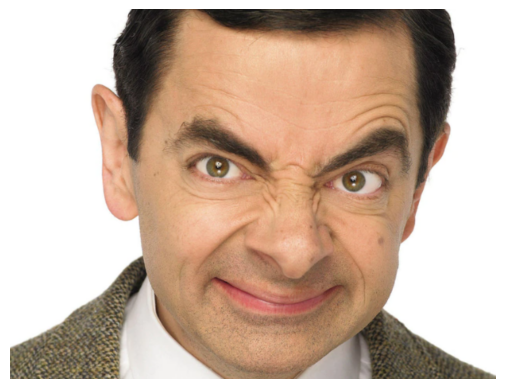

In [ ]:
Source_Image = "/content/user_upload/bean.png"  # @param {type: "string"}
display_image(Source_Image)


In [ ]:

#@title Upload Target Image (Where you want to paste the face)
import os
from google.colab import files
import shutil

upload_folder = '/content/user_upload'

if not os.path.exists(upload_folder):
    os.mkdir(upload_folder)

doner=[]
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)
  doner.append(dst_path)

from IPython.display import clear_output
clear_output()
doner[-1]

'/content/user_upload/istockphoto-1368965646-612x612.jpg'

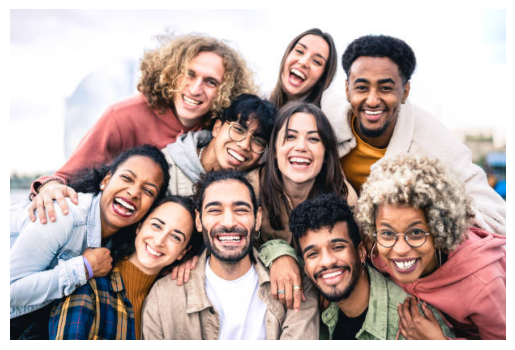

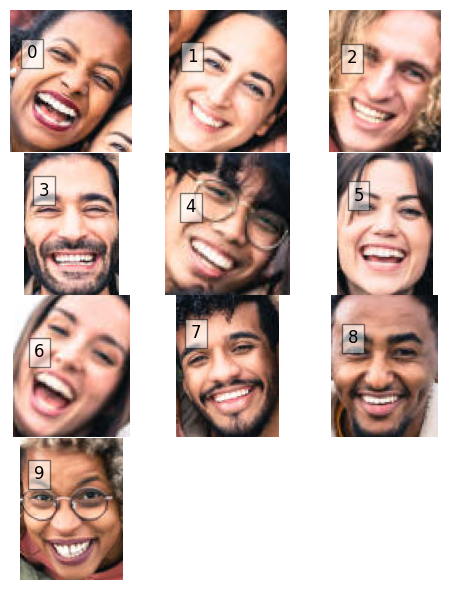

In [ ]:
Target_Image = "/content/user_upload/istockphoto-1368965646-612x612.jpg"  # @param {type: "string"}
# Credit: Getty Images
display_image(Target_Image)
face_dict,scan_face_path=scan_faces(Target_Image)

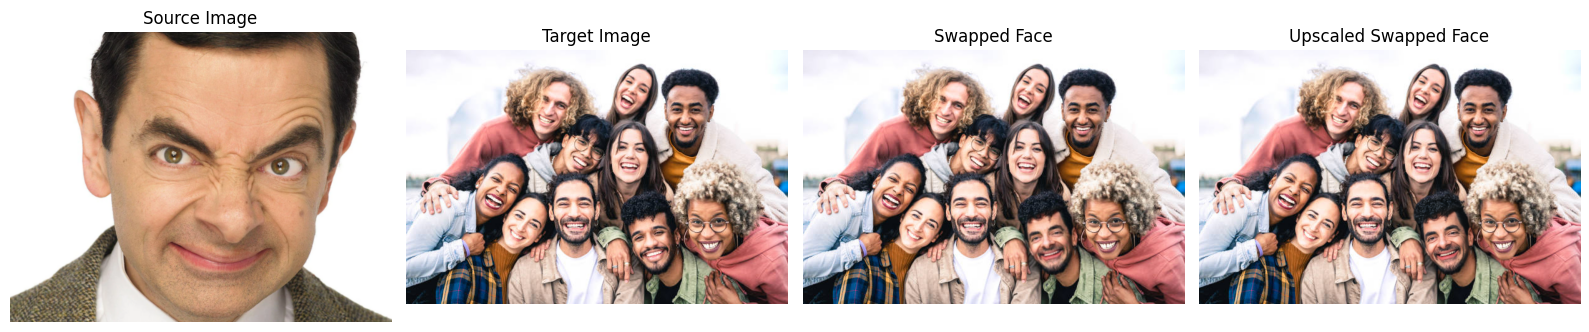

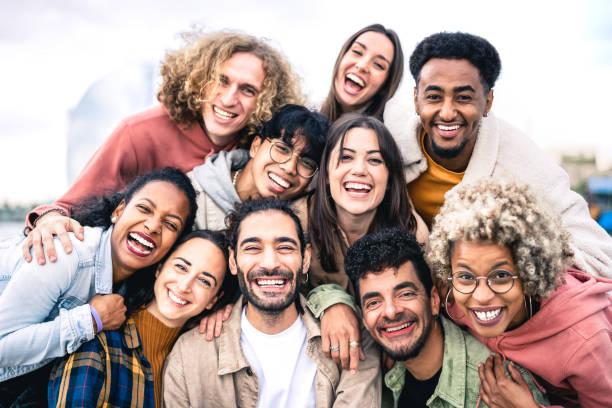

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
face_id = 7  # @param {type: "number"}
source_img_path=Source_Image
target_img_path=Target_Image
Upscale_Full_Image = False #@param {type:"boolean"}
img_swap, upscale_image_path=process_image(source_img_path,target_img_path,face_id,Upscale_Full_Image)
from IPython.display import clear_output
clear_output()
display_images(Source_Image, Target_Image, img_swap, upscale_image_path)
# display_image(upscale_image_path)
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.imread(upscale_image_path))
Auto_Download = True #@param {type:"boolean"}
from google.colab import files
if Auto_Download:
  files.download(img_swap)
  files.download(upscale_image_path)

In [ ]:
#@title Manually download
from google.colab import files
files.download(img_swap)
files.download(upscale_image_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>